In [1]:
import os.path as osp
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from model_utils import*
from mymodelzoo import*
from transforms import*
from utils import*
from adversary import*
from AdamOptimizer import*

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

GeForce GTX 1080 Ti


In [2]:
SEED = 888

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# trainset = TargetClassSet("./data/training.pt")
# trainloader = DataLoader(trainset, batch_size=1, num_workers=10)
# testset = TargetClassSet("./data/test.pt")
# testloader = DataLoader(testset, batch_size=1, num_workers=10)

In [37]:
import torchvision
from torchvision.transforms import transforms
trainset = TargetClassSet("./data/mnist_balanced_subset.pt")

trainloader = DataLoader(trainset, batch_size=1, num_workers=10, shuffle=True)

testset = torchvision.datasets.MNIST("/data/mnist", train=False, transform=transforms.ToTensor())
testloader = DataLoader(trainset, batch_size=1, num_workers=10)

In [30]:
model = LeNet().to(device)
#Load a checkpoint
ckp_out_root = './models/lenet'
ckp_dir = osp.join(ckp_out_root, "checkpoint.pth.tar")
if osp.isfile(ckp_dir):
    ckp = torch.load(ckp_dir)
    print(f"=> Loading checkpoint from {ckp_dir}")
    ckp_epoch = ckp["epoch"]
    best_test_acc = ckp["best_acc"]
    model.load_state_dict(ckp["state_dict"])
    print(f"=> Loaded checkpoint '{ckp_dir}' (epoch {ckp_epoch})")
    print(f"=> Best test acc. {best_test_acc}%")
else:
    print(f"No checkpoint found in {ckp_dir}")

=> Loading checkpoint from ./models/lenet/checkpoint.pth.tar
=> Loaded checkpoint './models/lenet/checkpoint.pth.tar' (epoch 2)
=> Best test acc. 99.0%


In [31]:
# T = [get_random_gaussian_pt(max_sigma=0.1),
#      get_random_rotate_kornia(max_deg=22.5),
#      get_random_contrast_pt(min_alpha=0.9, max_alpha=1.4),
#      get_random_brightness_pt(min_beta=-0.05, max_beta=0.05)]
T = [lambda x: x]
random_transform = RandomTransform(T)

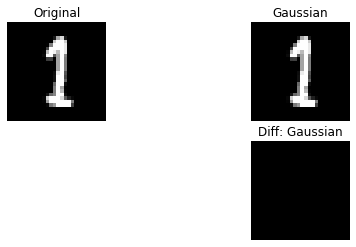

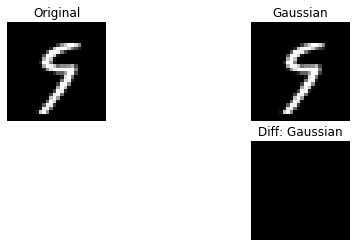

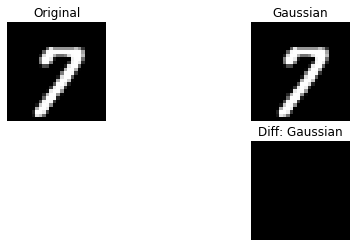

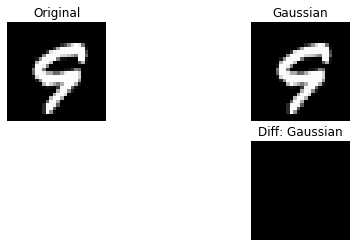

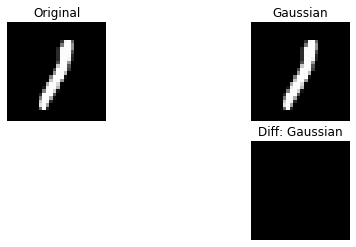

In [44]:
N = len(T)
demo_steps = 5
for i, (image, label) in enumerate(trainloader, 1):
    xt_list, label_list = [], ["Original", "Gaussian", "Rotate", "Contrast", "Brightness"]
    fig = plt.figure(figsize=(8, 4))
    ax = plt.subplot(2, N+1, 1)
    ax.set_title(label_list[0])
    plt.imshow(image[0][0].numpy(), cmap="gray")
    plt.axis("off")
    for t in T:
        xt_list.append(t(image))
    for c in range(2, N+2):
        ax = plt.subplot(2, N+1, c)
        ax.set_title(label_list[c-1])
        plt.imshow(xt_list[c-2][0][0].numpy(), cmap="gray")
        plt.axis("off")
        ax = plt.subplot(2, N+1, c+N+1)
        ax.set_title(f"Diff: {label_list[c-1]}")
        plt.imshow(xt_list[c-2][0][0].numpy() - image[0][0].numpy(), cmap="gray")
        plt.axis("off")
    plt.show()
    print("=======================================================")
    if i == demo_steps:
        break

In [41]:
epochs = 50
step_size = 5e-3
eps = 76.5/255.
log_interval = 5
optimizer = AdamOptimizer((1, 1, 28, 28), step_size, device)
criterion = get_clipped_loss(nn.CrossEntropyLoss(), float("-inf"), 6.)

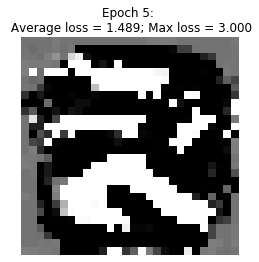

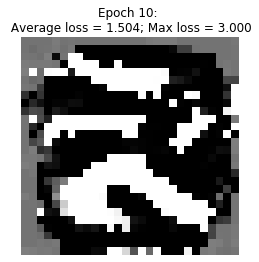

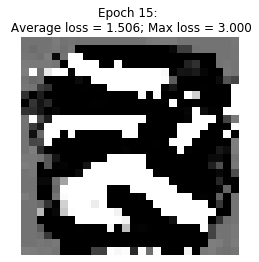

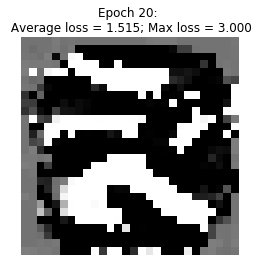

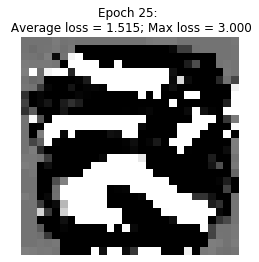

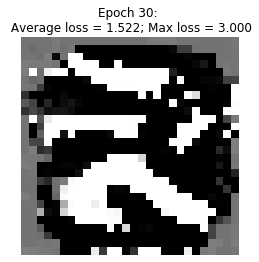

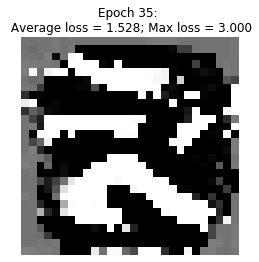

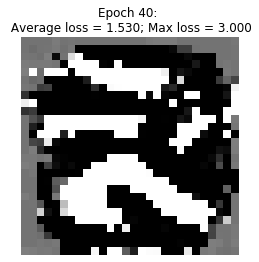

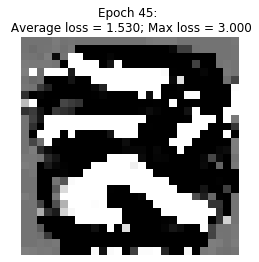

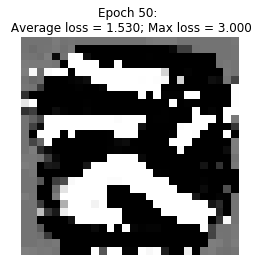

In [42]:
uni_pert = uni_eot_craft(model, T, trainloader,
                         epochs, step_size, eps, device, optimizer=optimizer,
                         criterion=criterion, log_interval=log_interval)

Success rate: 0.850


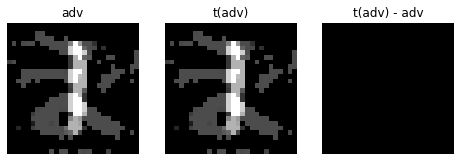

Success rate: 0.474


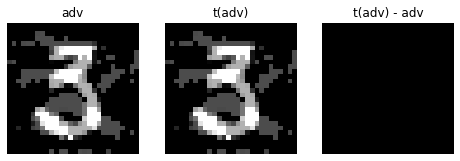

Success rate: 0.550


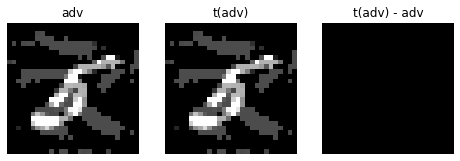

Success rate: 0.586


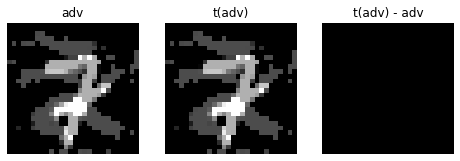

Success rate: 0.572


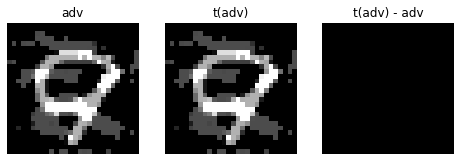

Success rate: 0.5724


In [43]:
succ_rate = uni_adv_eval(model, uni_pert, random_transform, 
                         testloader, device, log_interval=1000)
print(f"Success rate: {succ_rate}")